In [1]:
import videopipeline as vpl
import os
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def add_suffix(path, suffix, new_ext='.mp4'):
    return path.replace(os.path.splitext(path)[1], f'-{suffix}{new_ext}')

ffmpeg_path = r"C:\opt\ffmpeg-2022-02-17-git-2812508086-full_build\bin\ffmpeg.exe"
video_path = r"C:\Users\johny\Desktop\Sprung_Trim.mp4"
#video_path = r"C:\Users\johny\Desktop\coupdebain.mp4"
beat_path = r"C:\Users\johny\Desktop\Sprung.txt"
output_path = add_suffix(video_path, "absprung")
output_path = add_suffix(video_path, "stacked")
final_path = add_suffix(video_path, "final", ".mp4")
img_size = (90, 200)
crop_pos = (352 - 140, 640 // 2)

In [3]:
SMOOTH = 5
DENOISE_THRESHOLD = 30
DENOISE_FILTER = 40
AOA_SMOOTH = 15
ROLL = -3
HEIGHT = 3
DISTANCE = 50

In [4]:
def read_beats(beat_file, frame_count=4361):
    with open(beat_file) as f:
        lines = list(f)
        total, lines = float(lines[0]), lines[1:]
        beats = np.array(list(map(lambda t: np.full(frame_count, float(t) / total), lines)))
        frame_times = np.linspace(0, 1, num=frame_count)
        beat_frame_set = set(np.argmin(np.abs(beats - frame_times), axis=1))
        correct_frame = np.array([f'{i in beat_frame_set}' for i in range(frame_count)])

        return correct_frame


def add_audio_to_video(*args):
    combine_cmd = f"{ffmpeg_path} -y -i {output_path} -i {video_path} -map 0:v -map 1:a -r 30 -vf \"scale='iw-mod(iw,2)':'ih-mod(ih,2)',format=yuv420p\" -movflags +faststart {final_path}"
    rtrn = os.system(combine_cmd)
    assert rtrn == 0, rtrn
    return rtrn


class AbsprungDetector(vpl.core.Function):

    def __init__(self, **kwargs):
        super().__init__(self.absprung_detection, **kwargs)

    def absprung_detection(self, position_history):
        # read positions and smooth
        pos_raw = np.array([h if h is not None else [0, 0] for h in position_history])
        pos = np.zeros((pos_raw.shape[0], 2))

        # smooth
        pos[:, 0] = np.convolve(pos_raw[:, 0], np.ones(SMOOTH), mode="same") / SMOOTH
        pos[:, 1] = np.convolve(pos_raw[:, 1], np.ones(SMOOTH), mode="same") / SMOOTH

        # get movement vector from current and last position
        vec = np.array([np.abs(pos[i] - pos[max(0, i - 1)]) for i in range(pos.shape[0])])

        # get movement magnitude from movement vector
        mag = np.linalg.norm(vec, axis=1)
        mag_s = np.convolve(mag, np.ones(SMOOTH), mode="same") / SMOOTH # smooth

        # get angle of movement vector
        aoa_noisy = np.rad2deg(np.arctan2(vec[:, 0], vec[:, 1]))
        aoa_noisy_s = np.convolve(aoa_noisy, np.ones(SMOOTH), mode="same") / SMOOTH  # smooth

        aoa_s = aoa_noisy_s * ((np.convolve(aoa_noisy_s, np.ones(DENOISE_FILTER), mode='same') / DENOISE_FILTER ) > DENOISE_THRESHOLD)  # denoise
        aoa_diff = np.array([aoa_s[i] - aoa_s[max(0, i - 1)] for i in range(aoa_s.shape[0])])  # angle of attack difference
        aoa_diff_smooth = np.convolve(aoa_diff, np.ones(AOA_SMOOTH), mode="same") / AOA_SMOOTH # smooth
        aoa_diff_flip = np.abs(np.minimum(0, aoa_diff_smooth))  # filter negative and flip
        aoa_diff_off = np.roll(aoa_diff_flip, ROLL)  # offset signal
        absprung_set = set(find_peaks(aoa_diff_off, height=HEIGHT, distance=DISTANCE)[0])  # detect peaks
        absprung_frame = np.array([i in absprung_set for i in range(aoa_diff_off.shape[0])])  # write flag array

        return absprung_frame

## Absprung detection

In [22]:
raw_video = vpl.generators.ReadVideoFile(video_path)
grey = vpl.functions.Rgb2Greyscale()(raw_video)
warp = vpl.functions.PerspectiveTransformation(np.float32([(167, 218), (207, 244), (377, 193), (351, 173)]),
                                               np.float32([(0, 0), (0, 352), (640, 352), (640, 0)]),
                                               (640, 352))(grey)

#warp = vpl.functions.AffineTransformation((100., 100.), 15., 0.7)(grey)
writer = vpl.actions.VideoWriter(add_suffix(video_path, "warp"), 30,
                                 aggregate=True, collect=False, verbose=True)(warp)

vpl.core.Pipeline(writer)()

Aggregating 0
Aggregating 1
Aggregating 2
Aggregating 3
Aggregating 4
Aggregating 5
Aggregating 6
Aggregating 7
Aggregating 8
Aggregating 9
Aggregating 10
Aggregating 11
Aggregating 12
Aggregating 13
Aggregating 14
Aggregating 15
Aggregating 16
Aggregating 17
Aggregating 18
Aggregating 19
Aggregating 20
Aggregating 21
Aggregating 22
Aggregating 23
Aggregating 24
Aggregating 25
Aggregating 26
Aggregating 27
Aggregating 28
Aggregating 29
Aggregating 30
Aggregating 31
Aggregating 32
Aggregating 33
Aggregating 34
Aggregating 35
Aggregating 36
Aggregating 37
Aggregating 38
Aggregating 39
Aggregating 40
Aggregating 41
Aggregating 42
Aggregating 43
Aggregating 44
Aggregating 45
Aggregating 46
Aggregating 47
Aggregating 48
Aggregating 49
Aggregating 50
Aggregating 51
Aggregating 52
Aggregating 53
Aggregating 54
Aggregating 55
Aggregating 56
Aggregating 57
Aggregating 58
Aggregating 59
Aggregating 60
Aggregating 61
Aggregating 62
Aggregating 63
Aggregating 64
Aggregating 65
Aggregating 66
Aggre

[]

In [7]:
raw_video = vpl.generators.ReadVideoFile(video_path)
grey = vpl.functions.Rgb2Greyscale()(raw_video)
crop = vpl.functions.Crop(crop_pos, img_size)(grey)
smooth1 = vpl.functions.Smooth(21)(crop)
abs_diff = vpl.functions.AbsDiff()(smooth1)
threshold = vpl.functions.Threshold(32)(abs_diff)
dilate = vpl.functions.Dilate(25)(threshold)
smooth2 = vpl.functions.Smooth(11)(dilate)
canny_edge = vpl.functions.CannyEdge(1, 100)(smooth2)
find_contours = vpl.functions.FindContours()(canny_edge)

largest_contours = vpl.functions.FilterLargestContour()(find_contours)
convex = vpl.functions.ConvexHull()(largest_contours)
contour_center = vpl.functions.GetContourCenter(aggregate=True, collect=True)(convex)

contour_center_drawn1 = vpl.functions.DrawContourCenters()([canny_edge, contour_center])
movement_path_drawn1 = vpl.functions.DrawMovementPath(color_coeff=100)([contour_center_drawn1, contour_center])

stacked = vpl.functions.Stack(3, 3)([
    crop, smooth1, abs_diff,
    threshold, dilate, smooth2, 
    contour_center_drawn1, movement_path_drawn1
])
writer = vpl.actions.VideoWriter(add_suffix(video_path, "asdfasdf"), 30,
                                 aggregate=True, collect=False, verbose=True)(stacked)

pipeline_pos = vpl.core.Pipeline(writer)

In [8]:
pipeline_pos()

Aggregating 0
Aggregating 1
Aggregating 2
Aggregating 3
Aggregating 4
Aggregating 5
Aggregating 6
Aggregating 7
Aggregating 8
Aggregating 9
Aggregating 10
Aggregating 11
Aggregating 12
Aggregating 13
Aggregating 14
Aggregating 15
Aggregating 16
Aggregating 17
Aggregating 18
Aggregating 19
Aggregating 20
Aggregating 21
Aggregating 22
Aggregating 23
Aggregating 24
Aggregating 25
Aggregating 26
Aggregating 27
Aggregating 28
Aggregating 29
Aggregating 30
Aggregating 31
Aggregating 32
Aggregating 33
Aggregating 34
Aggregating 35
Aggregating 36
Aggregating 37
Aggregating 38
Aggregating 39
Aggregating 40
Aggregating 41
Aggregating 42
Aggregating 43
Aggregating 44
Aggregating 45
Aggregating 46
Aggregating 47
Aggregating 48
Aggregating 49
Aggregating 50
Aggregating 51
Aggregating 52
Aggregating 53
Aggregating 54
Aggregating 55
Aggregating 56
Aggregating 57
Aggregating 58
Aggregating 59
Aggregating 60
Aggregating 61
Aggregating 62
Aggregating 63
Aggregating 64
Aggregating 65
Aggregating 66
Aggre

Aggregating 534
Aggregating 535
Aggregating 536
Aggregating 537
Aggregating 538
Aggregating 539
Aggregating 540
Aggregating 541
Aggregating 542
Aggregating 543
Aggregating 544
Aggregating 545
Aggregating 546
Aggregating 547
Aggregating 548
Aggregating 549
Aggregating 550
Aggregating 551
Aggregating 552
Aggregating 553
Aggregating 554
Aggregating 555
Aggregating 556
Aggregating 557
Aggregating 558
Aggregating 559
Aggregating 560
Aggregating 561
Aggregating 562
Aggregating 563
Aggregating 564
Aggregating 565
Aggregating 566
Aggregating 567
Aggregating 568
Aggregating 569
Aggregating 570
Aggregating 571
Aggregating 572
Aggregating 573
Aggregating 574
Aggregating 575
Aggregating 576
Aggregating 577
Aggregating 578
Aggregating 579
Aggregating 580
Aggregating 581
Aggregating 582
Aggregating 583
Aggregating 584
Aggregating 585
Aggregating 586
Aggregating 587
Aggregating 588
Aggregating 589
Aggregating 590
Aggregating 591
Aggregating 592
Aggregating 593
Aggregating 594
Aggregating 595
Aggregat

Aggregating 1049
Aggregating 1050
Aggregating 1051
Aggregating 1052
Aggregating 1053
Aggregating 1054
Aggregating 1055
Aggregating 1056
Aggregating 1057
Aggregating 1058
Aggregating 1059
Aggregating 1060
Aggregating 1061
Aggregating 1062
Aggregating 1063
Aggregating 1064
Aggregating 1065
Aggregating 1066
Aggregating 1067
Aggregating 1068
Aggregating 1069
Aggregating 1070
Aggregating 1071
Aggregating 1072
Aggregating 1073
Aggregating 1074
Aggregating 1075
Aggregating 1076
Aggregating 1077
Aggregating 1078
Aggregating 1079
Aggregating 1080
Aggregating 1081
Aggregating 1082
Aggregating 1083
Aggregating 1084
Aggregating 1085
Aggregating 1086
Aggregating 1087
Aggregating 1088
Aggregating 1089
Aggregating 1090
Aggregating 1091
Aggregating 1092
Aggregating 1093
Aggregating 1094
Aggregating 1095
Aggregating 1096
Aggregating 1097
Aggregating 1098
Aggregating 1099
Aggregating 1100
Aggregating 1101
Aggregating 1102
Aggregating 1103
Aggregating 1104
Aggregating 1105
Aggregating 1106
Aggregating 11

Aggregating 1541
Aggregating 1542
Aggregating 1543
Aggregating 1544
Aggregating 1545
Aggregating 1546
Aggregating 1547
Aggregating 1548
Aggregating 1549
Aggregating 1550
Aggregating 1551
Aggregating 1552
Aggregating 1553
Aggregating 1554
Aggregating 1555
Aggregating 1556
Aggregating 1557
Aggregating 1558
Aggregating 1559
Aggregating 1560
Aggregating 1561
Aggregating 1562
Aggregating 1563
Aggregating 1564
Aggregating 1565
Aggregating 1566
Aggregating 1567
Aggregating 1568
Aggregating 1569
Aggregating 1570
Aggregating 1571
Aggregating 1572
Aggregating 1573
Aggregating 1574
Aggregating 1575
Aggregating 1576
Aggregating 1577
Aggregating 1578
Aggregating 1579
Aggregating 1580
Aggregating 1581
Aggregating 1582
Aggregating 1583
Aggregating 1584
Aggregating 1585
Aggregating 1586
Aggregating 1587
Aggregating 1588
Aggregating 1589
Aggregating 1590
Aggregating 1591
Aggregating 1592
Aggregating 1593
Aggregating 1594
Aggregating 1595
Aggregating 1596
Aggregating 1597
Aggregating 1598
Aggregating 15

Aggregating 2023
Aggregating 2024
Aggregating 2025
Aggregating 2026
Aggregating 2027
Aggregating 2028
Aggregating 2029
Aggregating 2030
Aggregating 2031
Aggregating 2032
Aggregating 2033
Aggregating 2034
Aggregating 2035
Aggregating 2036
Aggregating 2037
Aggregating 2038
Aggregating 2039
Aggregating 2040
Aggregating 2041
Aggregating 2042
Aggregating 2043
Aggregating 2044
Aggregating 2045
Aggregating 2046
Aggregating 2047
Aggregating 2048
Aggregating 2049
Aggregating 2050
Aggregating 2051
Aggregating 2052
Aggregating 2053
Aggregating 2054
Aggregating 2055
Aggregating 2056
Aggregating 2057
Aggregating 2058
Aggregating 2059
Aggregating 2060
Aggregating 2061
Aggregating 2062
Aggregating 2063
Aggregating 2064
Aggregating 2065
Aggregating 2066
Aggregating 2067
Aggregating 2068
Aggregating 2069
Aggregating 2070
Aggregating 2071
Aggregating 2072
Aggregating 2073
Aggregating 2074
Aggregating 2075
Aggregating 2076
Aggregating 2077
Aggregating 2078
Aggregating 2079
Aggregating 2080
Aggregating 20

Aggregating 2515
Aggregating 2516
Aggregating 2517
Aggregating 2518
Aggregating 2519
Aggregating 2520
Aggregating 2521
Aggregating 2522
Aggregating 2523
Aggregating 2524
Aggregating 2525
Aggregating 2526
Aggregating 2527
Aggregating 2528
Aggregating 2529
Aggregating 2530
Aggregating 2531
Aggregating 2532
Aggregating 2533
Aggregating 2534
Aggregating 2535
Aggregating 2536
Aggregating 2537
Aggregating 2538
Aggregating 2539
Aggregating 2540
Aggregating 2541
Aggregating 2542
Aggregating 2543
Aggregating 2544
Aggregating 2545
Aggregating 2546
Aggregating 2547
Aggregating 2548
Aggregating 2549
Aggregating 2550
Aggregating 2551
Aggregating 2552
Aggregating 2553
Aggregating 2554
Aggregating 2555
Aggregating 2556
Aggregating 2557
Aggregating 2558
Aggregating 2559
Aggregating 2560
Aggregating 2561
Aggregating 2562
Aggregating 2563
Aggregating 2564
Aggregating 2565
Aggregating 2566
Aggregating 2567
Aggregating 2568
Aggregating 2569
Aggregating 2570
Aggregating 2571
Aggregating 2572
Aggregating 25

Aggregating 3012
Aggregating 3013
Aggregating 3014
Aggregating 3015
Aggregating 3016
Aggregating 3017
Aggregating 3018
Aggregating 3019
Aggregating 3020
Aggregating 3021
Aggregating 3022
Aggregating 3023
Aggregating 3024
Aggregating 3025
Aggregating 3026
Aggregating 3027
Aggregating 3028
Aggregating 3029
Aggregating 3030
Aggregating 3031
Aggregating 3032
Aggregating 3033
Aggregating 3034
Aggregating 3035
Aggregating 3036
Aggregating 3037
Aggregating 3038
Aggregating 3039
Aggregating 3040
Aggregating 3041
Aggregating 3042
Aggregating 3043
Aggregating 3044
Aggregating 3045
Aggregating 3046
Aggregating 3047
Aggregating 3048
Aggregating 3049
Aggregating 3050
Aggregating 3051
Aggregating 3052
Aggregating 3053
Aggregating 3054
Aggregating 3055
Aggregating 3056
Aggregating 3057
Aggregating 3058
Aggregating 3059
Aggregating 3060
Aggregating 3061
Aggregating 3062
Aggregating 3063
Aggregating 3064
Aggregating 3065
Aggregating 3066
Aggregating 3067
Aggregating 3068
Aggregating 3069
Aggregating 30

Aggregating 3505
Aggregating 3506
Aggregating 3507
Aggregating 3508
Aggregating 3509
Aggregating 3510
Aggregating 3511
Aggregating 3512
Aggregating 3513
Aggregating 3514
Aggregating 3515
Aggregating 3516
Aggregating 3517
Aggregating 3518
Aggregating 3519
Aggregating 3520
Aggregating 3521
Aggregating 3522
Aggregating 3523
Aggregating 3524
Aggregating 3525
Aggregating 3526
Aggregating 3527
Aggregating 3528
Aggregating 3529
Aggregating 3530
Aggregating 3531
Aggregating 3532
Aggregating 3533
Aggregating 3534
Aggregating 3535
Aggregating 3536
Aggregating 3537
Aggregating 3538
Aggregating 3539
Aggregating 3540
Aggregating 3541
Aggregating 3542
Aggregating 3543
Aggregating 3544
Aggregating 3545
Aggregating 3546
Aggregating 3547
Aggregating 3548
Aggregating 3549
Aggregating 3550
Aggregating 3551
Aggregating 3552
Aggregating 3553
Aggregating 3554
Aggregating 3555
Aggregating 3556
Aggregating 3557
Aggregating 3558
Aggregating 3559
Aggregating 3560
Aggregating 3561
Aggregating 3562
Aggregating 35

Aggregating 4000
Aggregating 4001
Aggregating 4002
Aggregating 4003
Aggregating 4004
Aggregating 4005
Aggregating 4006
Aggregating 4007
Aggregating 4008
Aggregating 4009
Aggregating 4010
Aggregating 4011
Aggregating 4012
Aggregating 4013
Aggregating 4014
Aggregating 4015
Aggregating 4016
Aggregating 4017
Aggregating 4018
Aggregating 4019
Aggregating 4020
Aggregating 4021
Aggregating 4022
Aggregating 4023
Aggregating 4024
Aggregating 4025
Aggregating 4026
Aggregating 4027
Aggregating 4028
Aggregating 4029
Aggregating 4030
Aggregating 4031
Aggregating 4032
Aggregating 4033
Aggregating 4034
Aggregating 4035
Aggregating 4036
Aggregating 4037
Aggregating 4038
Aggregating 4039
Aggregating 4040
Aggregating 4041
Aggregating 4042
Aggregating 4043
Aggregating 4044
Aggregating 4045
Aggregating 4046
Aggregating 4047
Aggregating 4048
Aggregating 4049
Aggregating 4050
Aggregating 4051
Aggregating 4052
Aggregating 4053
Aggregating 4054
Aggregating 4055
Aggregating 4056
Aggregating 4057
Aggregating 40

[]

In [11]:
absprung_detector = AbsprungDetector()(pipeline_pos)
pipeline_absprung = vpl.core.Pipeline(absprung_detector)
absprunge = pipeline_absprung()

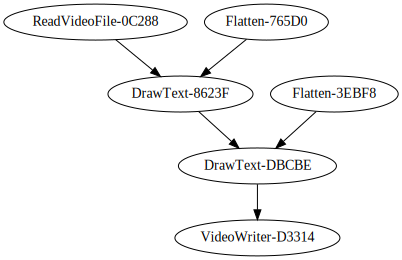

In [42]:
absprung_gen = vpl.generators.Flatten(absprunge)
beat_gen = vpl.generators.Flatten(read_beats(beat_path, 4360))

raw_video = vpl.generators.ReadVideoFile(video_path)
out_video = vpl.functions.DrawText(org=(50, 50), scale=0.8, thickness=2)([raw_video, absprung_gen])
out_video = vpl.functions.DrawText(org=(50, 80), scale=0.8, thickness=2)([out_video, beat_gen])

out_writer = vpl.actions.VideoWriter(output_path, 30, aggregate=True, collect=False)(out_video)

p = vpl.core.Pipeline(out_writer)
out_sound = vpl.core.Action(add_audio_to_video)(p)
p.render_model()

In [43]:
out_sound()

[]

## Detect absprung

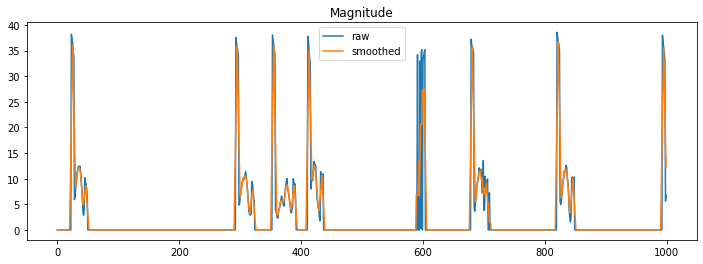

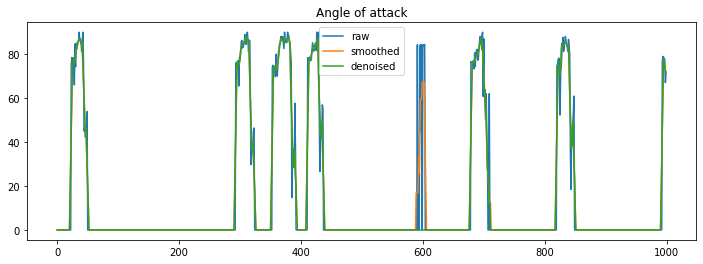

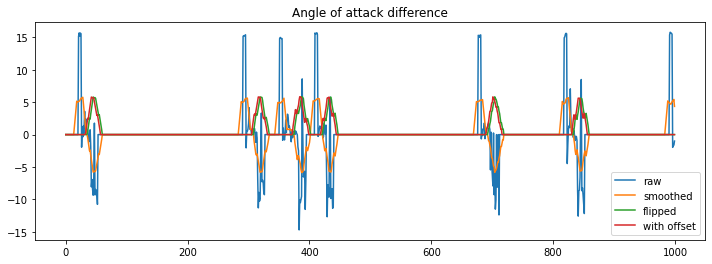

In [15]:
s = slice(1000, 2000)
plt.figure(figsize=(12,4))
plt.title("Magnitude")
plt.plot(mag[s], label="raw")
plt.plot(mag_s[s], label="smoothed")
plt.legend()

plt.figure(figsize=(12,4))
plt.title("Angle of attack")
plt.plot(aoa_noisy[s], label="raw")
plt.plot(aoa_noisy_s[s], label="smoothed")
plt.plot(aoa_s[s], label="denoised")
plt.legend()

plt.figure(figsize=(12,4))
plt.title("Angle of attack difference")
plt.plot(aoa_diff[s], label="raw")
plt.plot(aoa_diff_smooth[s], label="smoothed")
plt.plot(aoa_diff_flip[s], label="flipped")
plt.plot(aoa_diff_off[s], label="with offset")
plt.legend()